In [9]:
import numpy as np
import matplotlib as mpl
import matplotlib.colors as pltclr
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, AutoMinorLocator
from scipy.optimize import curve_fit, fsolve
import scipy.io as sio
import os
import re
import math

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.family"] = "Arial"

color_codes = ['#4477AA','#AA3377', '#228833', '#CCBB44', '#EE6677', '#66CCEE']*2
def NewRainbow():
    cols = [(0,0,0)]
    for x in np.linspace(0,1, 254):
        rcol = (0.472-0.567*x+4.05*x**2)/(1.+8.72*x-19.17*x**2+14.1*x**3)
        gcol = 0.108932-1.22635*x+27.284*x**2-98.577*x**3+163.3*x**4-131.395*x**5+40.634*x**6
        bcol = 1./(1.97+3.54*x-68.5*x**2+243*x**3-297*x**4+125*x**5)
        cols.append((rcol, gcol, bcol))
    cols.append((1,1,1))
    return pltclr.LinearSegmentedColormap.from_list("PaulT_rainbow", cols)
cm_rainbow = NewRainbow()


def ShirleyBackground(E_list, I_list):
    total_num = len(E_list)
    if total_num != len(I_list):
        return 0
    
    E_list = np.asarray(E_list)
    I_list = np.asarray(I_list)
    E_left = E_list[0]
    I_left = I_list[0]
    E_right = E_list[-1]
    I_right = I_list[-1]
    
    k0= (I_left - I_right)/np.trapz(I_list - I_right, E_list)
    bg0 = []
    for i in range(total_num):
        bg_i = k0 * np.trapz(I_list[i:] - I_right, E_list[i:])
        bg0.append(bg_i)
    bg = bg0 = np.asarray(bg0)
    
    while True:
        bg_prev = bg    
        bg = []
        k = (I_left - I_right) / np.trapz(I_list - I_right - bg_prev, E_list)
        
        for i in range(total_num):
            bg_i = k * np.trapz(I_list[i:] - I_right - bg_prev[i:], E_list[i:])
            bg.append(bg_i)
        bg = np.asarray(bg)
        if np.sum((bg_prev - bg)**2) / np.sum(bg**2) < 1/10**6:
            break
            
    return I_list - bg - I_right


def VoigtProfile(x,m,s,i,c):
    return (1-c)*i/s*np.exp(-(x-m)**2/s**2)+c*i*s/((x-m)**2+s**2)


def FitFunc(d):
    def func(x, *arg):
        ret = 0
        for i in range(d):
            ret += VoigtProfile(x, arg[4*i], arg[4*i+1], arg[4*i+2], arg[4*i+3])
        return ret
    
    def func_list(x, *arg, reverse=True):
        ret = list()
        for i in range(d):
            key = arg[4*i]
            ret.append([key, VoigtProfile(x, arg[4*i], arg[4*i+1], arg[4*i+2], arg[4*i+3])])
            
        funcs = []
        if reverse:
            ret = sorted(ret, key=lambda x: x[0])
            for key, func in ret:
                funcs.append(func)
        if reverse:
            ret = sorted(ret, key=lambda x: -x[0])
            for key, func in ret:
                funcs.append(func)
        return funcs
    return func, func_list


def Doublet_FitFunc(d, offset, num, doublet_ratio):
    def func(x, *arg):
        ret = 0
        for i in range(d):
            if i < num:
                ret += (VoigtProfile(x, arg[4*i], arg[4*i+1], arg[4*i+2], arg[4*i+3]) 
                        + VoigtProfile(x, arg[4*i] + offset, arg[4*i+1], arg[4*i+2]*doublet_ratio, arg[4*i+3]))
            else:
                ret += VoigtProfile(x, arg[4*i], arg[4*i+1], arg[4*i+2], arg[4*i+3])
        return ret
    
    def func_list(x, *arg, reverse=True):
        ret = list()
        for i in range(d):
            key = arg[4*i]
            if i < num:
                ret.append([key, VoigtProfile(x, arg[4*i], arg[4*i+1], arg[4*i+2], arg[4*i+3])])
                ret.append([key + offset, VoigtProfile(x, arg[4*i] + offset, arg[4*i+1], arg[4*i+2]*doublet_ratio, arg[4*i+3])])
            else:
                ret.append([key, VoigtProfile(x, arg[4*i], arg[4*i+1], arg[4*i+2], arg[4*i+3])])
            
        funcs = []
        if reverse:
            ret = sorted(ret, key=lambda x: x[0])
            for key, func in ret:
                funcs.append(func)
        if reverse:
            ret = sorted(ret, key=lambda x: -x[0])
            for key, func in ret:
                funcs.append(func)
        return funcs
    return func, func_list


def TickScaleSelector(interval):
    def MantissaExponent(value):
        if value > 0:
            exponent = math.floor(math.log10(value))
            mantissa = value / (10**exponent)
        elif value == 0:
            mantissa = 0
            exponent = 0
        else:
            exponent = math.floor(math.log10(-value))
            mantissa = value / 10 ** exponent
        return (mantissa, exponent)
    
    
    mantis, expon = MantissaExponent(interval)
    
    if mantis < 2:
        ret = .2 * 10**expon
    elif mantis < 4:
        ret = .4 * 10**expon
    elif mantis < 8:
        ret = 1 * 10**expon
    elif mantis < 10:
        ret = 2 * 10**expon
    else:
        ret = 0
    return ret


class XpsData(object):
    def __init__(self, path):
        self.file_path = path
        self.fileBase, self.extension = os.path.splitext(self.file_path)
        self.x_list = []
        self.y_list = []
        self.fit_list = []
        self.x_min = -np.inf
        self.x_max = np.inf
        self.x_cut = []
        self.y_cut = []
        self.x_cut_reveres = []
        
    def load_data(self):
        with open(self.file_path,'r') as f:
            dat = f.read().split('\n')
            
        for line in dat:
            try:
                x, y = line.split(',')
            except:
                continue
            self.x_list.append(float(x))
            self.y_list.append(float(y))
        self.x_list = np.asarray(self.x_list)
        self.y_list = np.asarray(self.y_list)
        
    def get_fitting(self, fit_range=None, bounds=None, peak_num=1, mix_coeff=None, doublet_offset=0, doublet_num=0, doublet_ratio=1):
        if fit_range is not None:
            self.x_min, self.x_max = fit_range
        else:
            self.x_min = min(self.x_list)
            self.x_max = max(self.x_list)
        self.x_cut = self.x_list[np.logical_and(self.x_list > self.x_min, self.x_list < self.x_max)]
        self.y_cut = self.y_list[np.logical_and(self.x_list > self.x_min, self.x_list < self.x_max)]
        self.y_cut = self.y_cut - min(self.y_cut)
        self.y_cut = ShirleyBackground(self.x_cut, self.y_cut)
        
        if doublet_num == 0 or doublet_offset == 0:
            func, funclist = FitFunc(peak_num)
        else:
            func, funclist = Doublet_FitFunc(peak_num, doublet_offset, doublet_num, doublet_ratio)
            
        if bounds is None:
            initVal = list()
            lowerbd = list()
            upperbd = list()
            if mix_coeff is None:
                mix_coeff_min = 0
                mix_coeff_max = 1
            else:
                mix_coeff_min, mix_coeff_max = mix_coeff

            for i in range(peak_num):
                initVal += [(self.x_min + self.x_max)/2, 0.5, max(self.y_cut)/10, (mix_coeff_max+mix_coeff_min)/2]
                lowerbd += [self.x_min, 0, 0, mix_coeff_min]
                upperbd += [self.x_max, np.inf, np.inf, mix_coeff_max]
            bounds = (lowerbd, upperbd)
        else:
            bounds = np.asarray(bounds)
            lowerbd, upperbd = np.transpose(bounds)
            lowerbd = np.transpose(lowerbd).flatten()
            upperbd = np.transpose(upperbd).flatten()
            initVal = (lowerbd + upperbd)/2

        plot_range = (self.x_min, self.x_max)
        popt, pconv = curve_fit(func, self.x_cut, self.y_cut, initVal, bounds=(lowerbd, upperbd))
        self.x_cut_reverse = (self.x_min + self.x_max) - self.x_cut

        fig = plt.figure(figsize=(5,4), dpi=300)            
        ax1 = fig.add_subplot(111)

        indevFit = funclist(self.x_cut, *popt)
        if peak_num >= 1:    
            for f, c in zip(indevFit, color_codes[0:len(indevFit)-1]):
                plt.plot(self.x_cut_reverse, f, color=c)
                ax1.fill_between(self.x_cut_reverse, f, 0, color=c, alpha=0.2)
            plt.plot(self.x_cut_reverse, func(self.x_cut, *popt), 'k')
        else:
            plt.plot(self.x_cut_reverse, func(self.x_cut, *popt), color=color_codes[0])
            ax1.fill_between(self.x_cut_reverse, func(self.x_cut, *popt), 0, color=color_codes[0], alpha=0.2)
        plt.plot(self.x_cut_reverse, self.y_cut, 'ko', markerfacecolor='white')
        ax1.set_xlabel('Binding Energy (eV)', fontsize=12)
        ax1.set_ylabel('Counts (s)', fontsize=12)
        ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
        ax1.set_xlim(plot_range)
        ax1.set_xticklabels([(self.x_min + self.x_max) - tick for tick in ax1.get_xticks()])
        ax1.relim()
        plt.tight_layout()
        plt.savefig(self.fileBase + '_from_'+str(self.x_min)+'_to_'+str(self.x_max)+'.pdf')
        plt.savefig(self.fileBase + '_from_'+str(self.x_min)+'_to_'+str(self.x_max)+'.png')
        plt.show()
        self.fit_list = popt.tolist()
        print(self.fit_list)

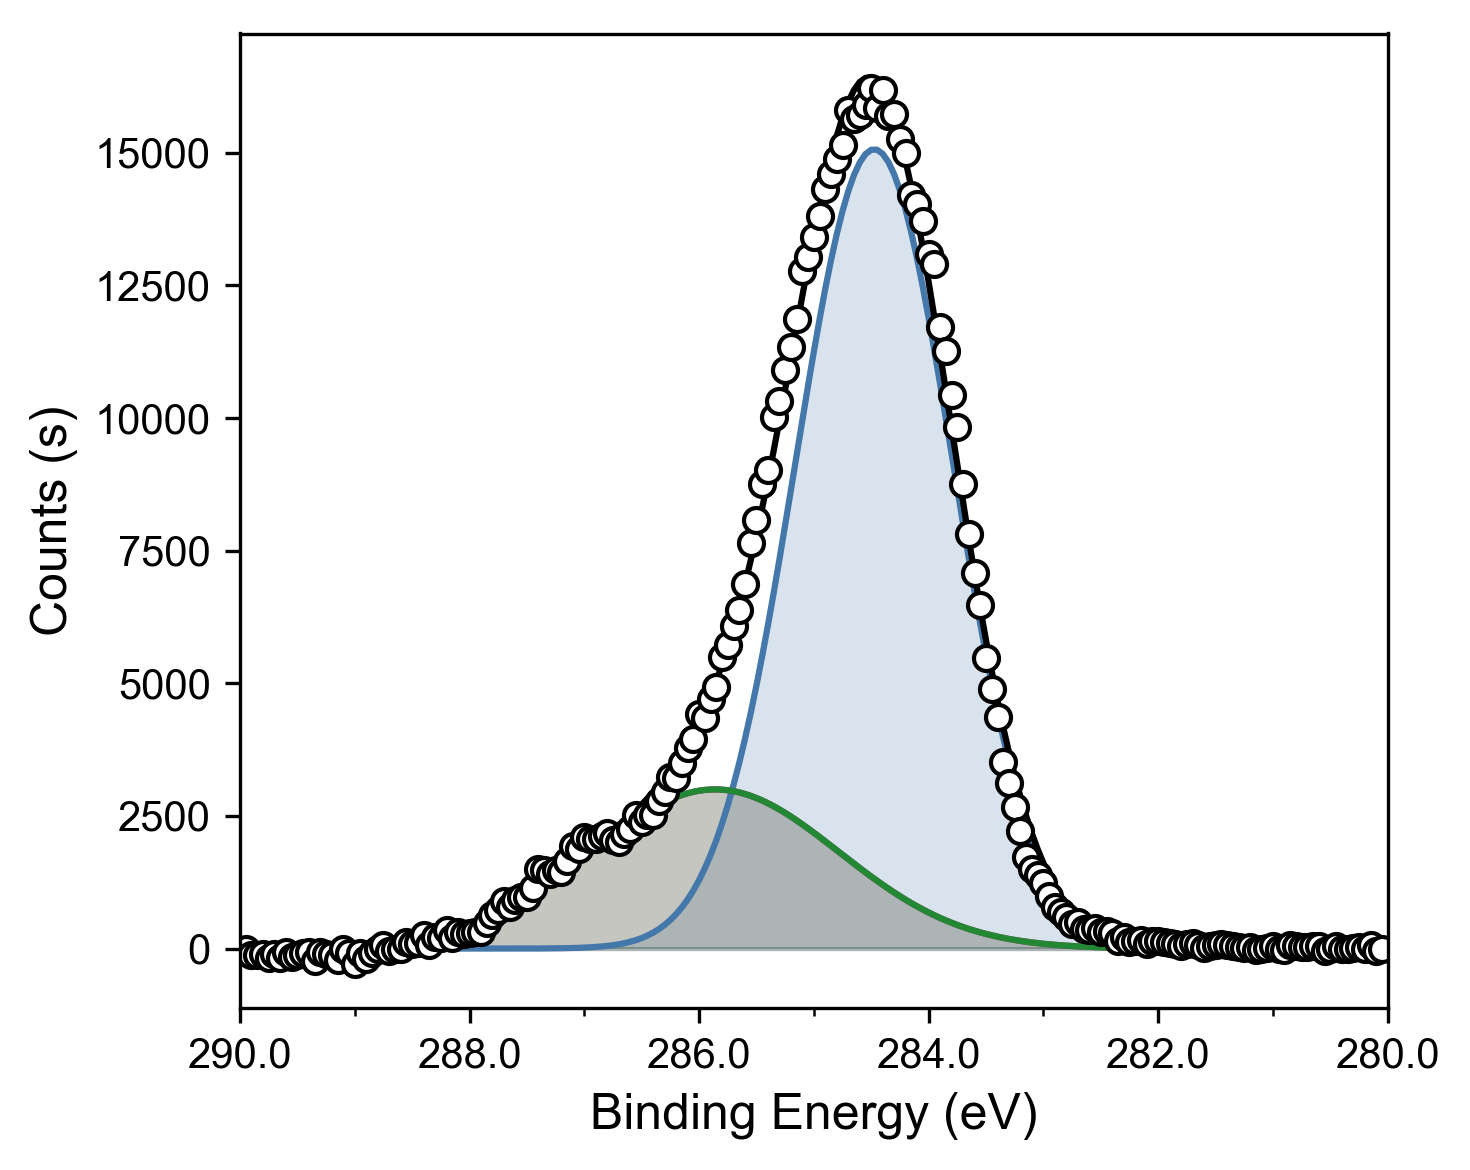

[284.47410971632394, 0.9733415759683857, 14666.677182161831, 2.4406616151547136e-35, 285.86080318312764, 1.527470404026341, 4582.517566059007, 2.5869104271234548e-31]


In [11]:
file_path = r"C:\Users\ANDONG\Desktop\data.csv"
file_path = file_path.replace('"', '')
data = XpsData(file_path)
data.load_data()
data.get_fitting(peak_num=2, fit_range=(280, 290), mix_coeff=(0,0.5))

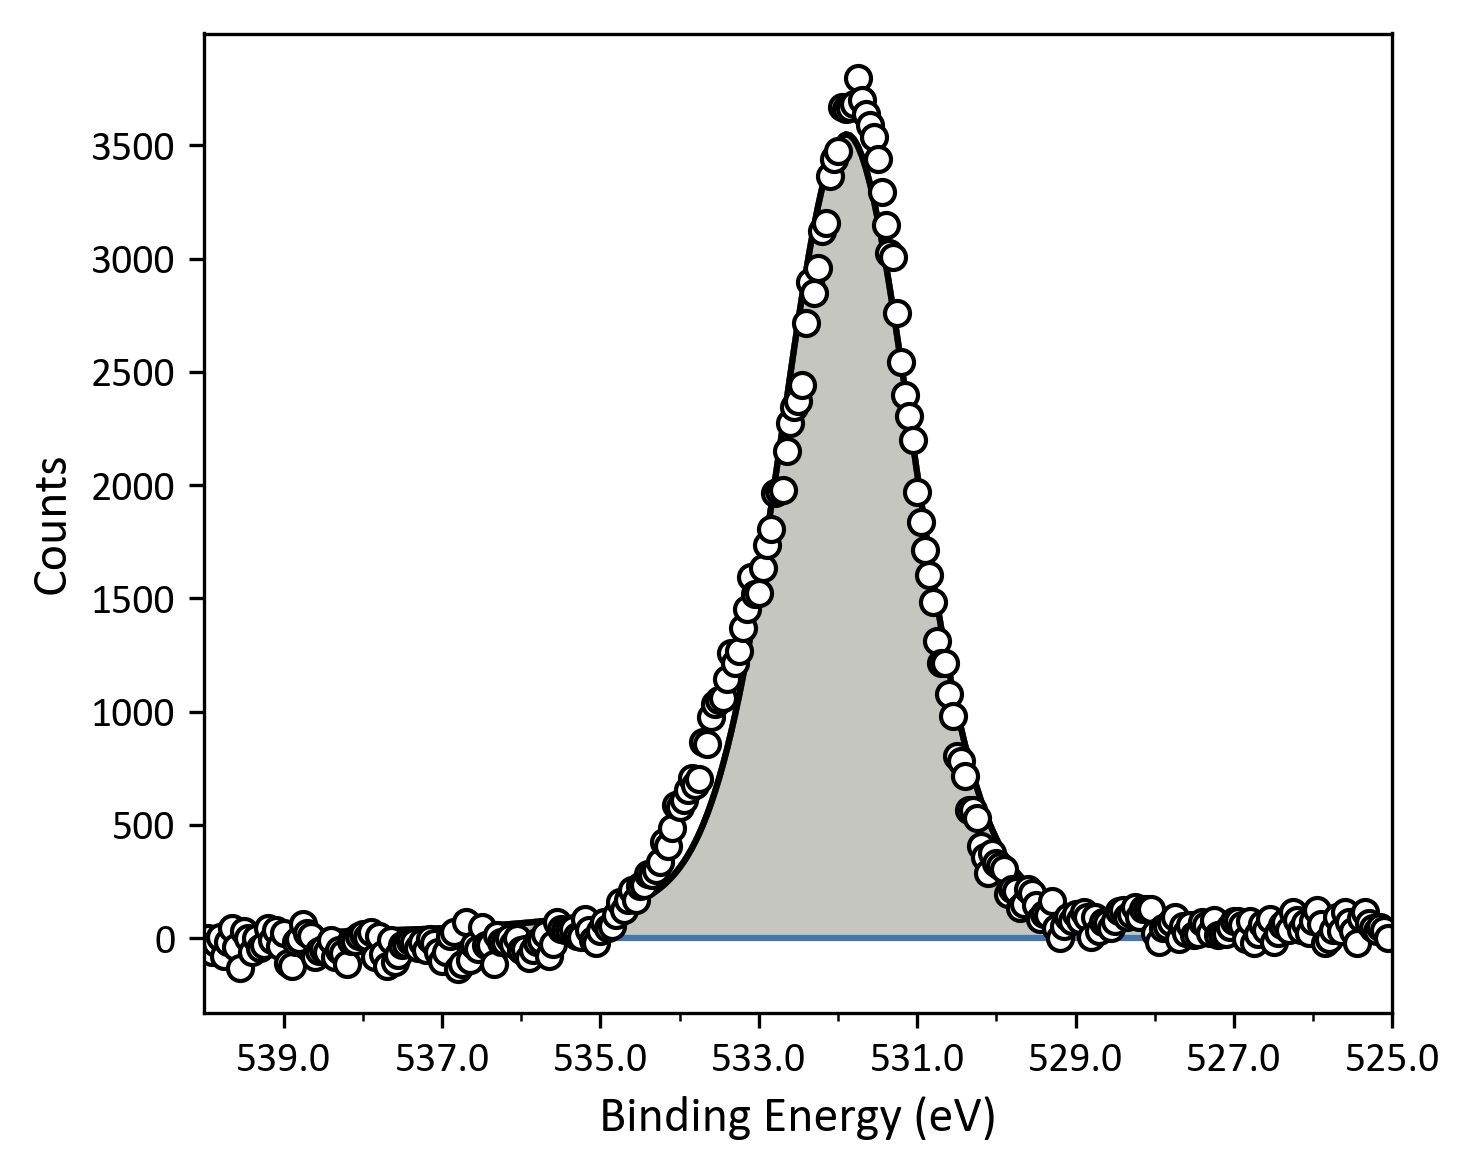

[530.0000000000001, 19.99999999673581, 1.2172896990689605e-06, 2.8933392007708203e-13, 531.8919494816442, 1.1693692857180944, 4150.70197701166, 0.24882628146144892]


In [97]:
file_path = r"D:\Dropbox\업무\연구\실험 데이터\_Collaborations\PS\XPS\data\2_O1s.csv"
file_path = file_path.replace('"', '')
data = XpsData(file_path)
data.load_data()
data.get_fitting(peak_num=2, doublet_num=0, fit_range= (525, 540),bounds=(((530,531.5),(0,20),(0,15000),(0,1)), ((530.5,535),(0,10),(0,10000),(0,1))))

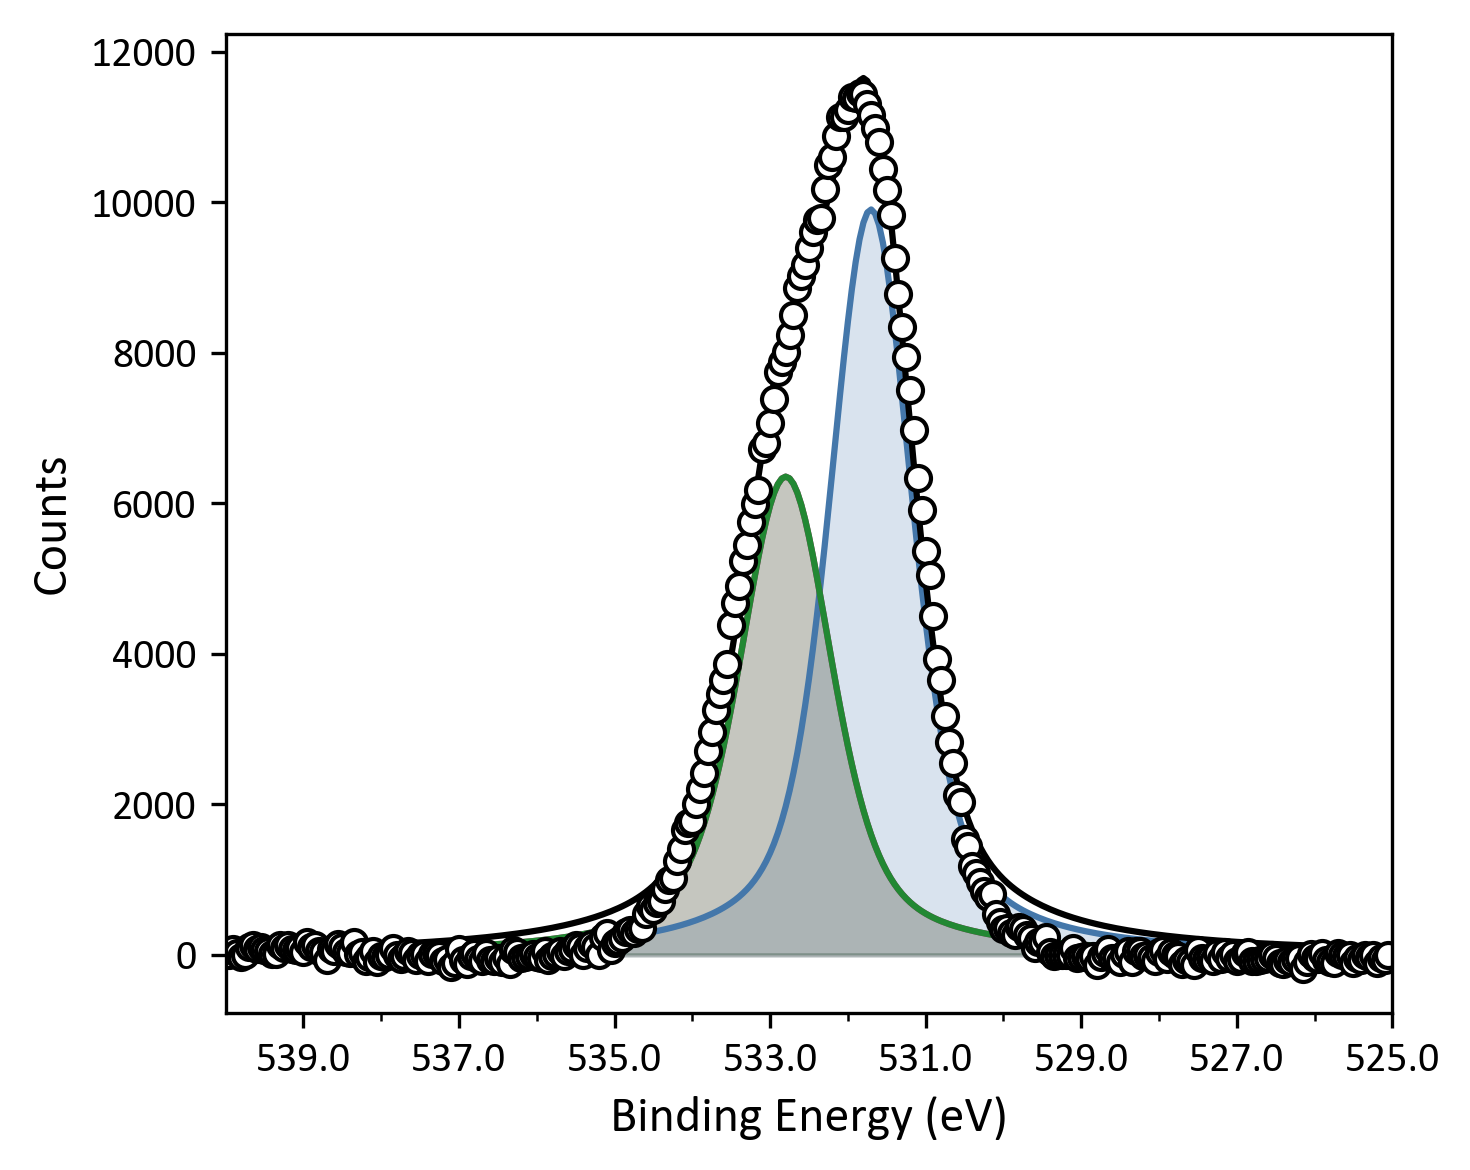

[531.7039399289091, 0.7179845497822622, 7113.317993517136, 0.5000000000000001, 532.7984078073412, 0.8020883114953412, 5098.088447388237, 0.5000000000000001]


In [60]:
file_path = r"D:\Dropbox\업무\연구\논문 작업\공동 연구 작업\2019 우성욱 논문 작업\xps_Serratia sp. WSW\Experimental_O1s.csv"
file_path = file_path.replace('"', '')
data = XpsData(file_path)
data.load_data()
data.get_fitting(peak_num=2, doublet_num=0, fit_range=(525, 540),mix_coeff=(0.5,1))

In [40]:
target_dir = r"D:\Dropbox\업무\연구\논문 작업\공동 연구 작업\2019 우성욱 논문 작업\xps_Serratia sp. WSW"
files = os.listdir(target_dir)
for file in files:
    with open(os.path.join(target_dir,file), 'r') as f:
        cont = f.read()
        new_cont = ''
        lines = cont.split('\n')[4:-3]
        for line in lines:

            seps = line.split('\t')
            new_line = '{},{}\n'.format(seps[1], seps[2])
            new_cont += new_line
    new_cont = new_cont[:-1]
    with open(os.path.join(target_dir, file + '.csv'),'w') as f:
        f.write(new_cont)

In [2]:
file_path = r"C:\Users\songi\Desktop\Syn_powder0001.csv"

In [15]:
def shift_file(file_name, shift_value):
    import os
    
    with open(file_name, 'r') as f:
        cont = f.read()
    lines = cont.split('\n')
    new_lines = []
    
    for line in lines:
        try:
            energy, counts = line.split(',')
        except:
            break
        new_energy = float(energy) + shift_value
        new_lines.append('{},{}\n'.format(new_energy, counts))
        
    file_base, file_ext = os.path.splitext(file_name)
    with open(file_base + '.shifted' + file_ext ,'w') as f:
        f.write(''.join(new_lines))


In [19]:
peak_a = [284.47410971632394, 0.9733415759683857, 14666.677182161831, 2.4406616151547136e-35]
peak_b = [285.86080318312764, 1.527470404026341, 4582.517566059007, 2.5869104271234548e-31]

In [14]:
from scipy.integrate import trapz

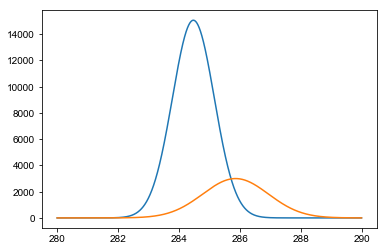

In [28]:
x_list = np.arange(280, 290, 0.001)
a_list = VoigtProfile(x_list, *peak_a)
b_list = VoigtProfile(x_list, *peak_b)
plt.plot(x_list, a_list)
plt.plot(x_list, b_list)
plt.show()

In [27]:
trapz(b_list,x_list)/trapz(a_list, x_list)

0.3124242383051783